In [1]:
import sys; sys.path.append("..")
from critical_ai_2026 import *


In [2]:
from hashstash import HashStash
import pandas as pd
from tqdm import tqdm
STASH_EMO_ANNO = HashStash(os.path.abspath("../data/emogens4"))
# STASH_EMO_ANNO.clear()
STASH_EMO_ANNO

Config,Param,Value
Path,Root Dir,/Users/ryan/github/critical-ai-2026/data/emogens4
,Filename,data.db
Engine,Engine,lmdb
,Serializer,hashstash
,Compress,lz4
,B64,True
Stats,Len,1097


In [3]:
PATH_EMO_PROMPTS = "../prompts/emotion"

def get_emo_prompts():
    out = {}
    for fn in os.listdir(PATH_EMO_PROMPTS):
        if fn.endswith(".txt"):
            with open(os.path.join(PATH_EMO_PROMPTS, fn), "r") as f:
                out[fn.replace(".txt","")] = f.read()
    return out


In [4]:
# get_emo_prompts()

In [5]:
ANNO_SYS_PROMPT = """INSTRUCTIONS: Read the following (1) emotion taxonomy and (2) passage, then choose which emotion categories are present in the passage. Return your answer in a JSON dictionary. The keys are the categories that you have chosen (each string must be the exact match of the category chosen), and their values are lists of strings matching 1-3 of the phrases from the passage most indicative of that category."""

def annotate_emotions_study(passage, study_name, model=DEFAULT_MODEL, verbose=True, **kwargs):
    dbkey = (passage,study_name,model)
    dbres = STASH_EMO_ANNO.get(dbkey, None)
    if dbres is not None:
        return dbres
    
    base_prompt = get_emo_prompts().get(study_name, None)
    if base_prompt is None:
        raise ValueError(f"Study name {study_name} not found in {PATH_EMO_PROMPTS}")
    
    system_prompt = f"{ANNO_SYS_PROMPT}\n\n(1) EMOTION TAXONOMY:\n{base_prompt}"
    user_prompt = f"(2) PASSAGE:\n{passage}"
    data = generate_json(user_prompt, system_prompt=system_prompt, model=model, max_tokens=1_000, verbose=False)
    STASH_EMO_ANNO[dbkey] = data
    return data


In [6]:
# poem = generate_text("Write a poem.")

In [7]:
# annotate_emotions_study(poem, "Bradley Lang 1992")

In [8]:
EMO_STUDIES = [
    'Bradley Lang 1992',
    'Cowen Keltner 2017',
    'Descartes 1649',
    # 'Ekman 1992',
    # 'Ekman 1999',
    # 'Humaine 2006',
    # 'James 1890',
    # 'Kort Reilly Picard 2001',
    # 'Lazarus 1996',
    # 'Mehrabian Russell 1980',
    # 'Parrott 2001',
    # 'Plutchik 1980',
    # 'Robinson 2009',
    # 'Russell 1980',
    # 'Schlosberg 1954',
    # 'Shaver 1987',
    # 'Watson Tellegen 1985',
    # 'Watt Smith 2016',
    'Wundt 1897'
]

In [9]:
def annotate_emotions(passage, model=DEFAULT_MODEL, verbose=True, emo_studies=EMO_STUDIES, **kwargs):
    out = []
    for emosys in emo_studies:
        emo_res = annotate_emotions_study(passage, emosys, model=model, verbose=verbose)
        if emo_res is None:
            continue
        for emocat, egs in emo_res.items():
            for eg in egs:
                out.append({
                    "emosys":emosys,
                    "emocat":emocat,
                    "eg":eg,
                })
    odf = pd.DataFrame(out)
    return odf

In [10]:
poem = """
The trees are in their autumn beauty,
The woodland paths are dry,
Under the October twilight the water
Mirrors a still sky;
Upon the brimming water among the stones
Are nine-and-fifty swans.

The nineteenth autumn has come upon me
Since I first made my count;
I saw, before I had well finished,
All suddenly mount
And scatter wheeling in great broken rings
Upon their clamorous wings.

I have looked upon those brilliant creatures,
And now my heart is sore.
All's changed since I, hearing at twilight,
The first time on this shore,
The bell-beat of their wings above my head,
Trod with a lighter tread.

Unwearied still, lover by lover,
They paddle in the cold
Companionable streams or climb the air;
Their hearts have not grown old;
Passion or conquest, wander where they will,
Attend upon them still.

But now they drift on the still water,
Mysterious, beautiful;
Among what rushes will they build,
By what lake's edge or pool
Delight men's eyes when I awake some day
To find they have flown away?
"""

In [11]:
# annotate_emotions(poem)
# annotate_emotions("Hello bright and sunny day!")

In [12]:
df_gen_completions = pd.read_csv("/Users/ryan/github/generative-formalism/data/data_as_in_paper/genai_rhyme_completions.csv.gz")
df_meta = pd.read_csv("/Users/ryan/github/generative-formalism/data/raw/corpus/chadwyck_corpus_metadata.csv.gz")
id2period = dict(zip(df_meta.id, df_meta.year.apply(lambda x: f"{int(x//100)*100}s")))
# id2period

In [44]:
def get_df_smpl(lim=10, min_lines=10):
    o = []
    gby = ["id_human","model","first_n_lines","id"]
    for i,(g,gdf) in enumerate(df_gen_completions.groupby(gby)):
        if len(o) >= (lim*3):
            break
        gdf2 = gdf.dropna(subset=["line_gen"])
        if len(gdf2) < min_lines:
            continue
        
        gd = dict(zip(gby, g))
        gd["period"] = id2period[gd["id_human"]]
        
        gdf0 = gdf[gdf.line_gen.isna()]
        poem_txt_init = gdf0.line_real.str.cat(sep="\n")
        poem_txt_human = gdf2.line_real.str.cat(sep="\n")
        poem_txt_gen = gdf2.line_gen.str.cat(sep="\n")

        poem_txt_init = "\n".join([x.strip() for x in poem_txt_init.split("\n") if x.strip()])
        num_lines_init = len(poem_txt_init.split("\n"))
        num_lines_human = len(poem_txt_human.split("\n"))
        num_lines_gen = len(poem_txt_gen.split("\n"))

        # poem_txt_human = "\n".join([x.strip() for x in poem_txt_human.split("\n") if x.strip()][:num_lines_init])
        # poem_txt_gen = "\n".join([x.strip() for x in poem_txt_gen.split("\n") if x.strip()][:num_lines_init])
        
        o.append({
            **gd,
            "source":"prompt",
            "txt_trunc":poem_txt_init,
            "num_lines":num_lines_init,
        })
        o.append({
            **gd,
            "source":"human",
            "txt_trunc":poem_txt_human,
            "num_lines":num_lines_human,
        })
        o.append({
            **gd,
            "source":"genai",
            "txt_trunc":poem_txt_gen,
            "num_lines":num_lines_gen,
        })
    return pd.DataFrame(o)



In [45]:
def annotate_emotion_mp(poem_txts, model=DEFAULT_MODEL, verbose=False, n_workers=None):
    """Annotate emotions for multiple poems in parallel using a thread pool."""
    from concurrent.futures import ThreadPoolExecutor, as_completed

    if n_workers is None:
        n_workers = min(4, len(poem_txts))

    results = [None] * len(poem_txts)

    def _annotate(idx_txt):
        idx, txt = idx_txt
        return idx, annotate_emotions(txt, model=model, verbose=False)

    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        futures = {executor.submit(_annotate, (i, txt)): i for i, txt in enumerate(poem_txts)}
        for future in tqdm(as_completed(futures), total=len(poem_txts), desc="Annotating poems", disable=not verbose):
            idx, df = future.result()
            results[idx] = df.assign(txt_trunc=poem_txts[idx])

    return pd.concat(results).reset_index(drop=True)

In [46]:
df_smpl = get_df_smpl(lim=200)
# df_smpl

In [47]:
odf = annotate_emotion_mp(
    df_smpl.txt_trunc.tolist(), 
    model="openai/gpt-3.5-turbo", 
    verbose=True, 
    n_workers=8
)
odf

Annotating poems:   0%|          | 0/600 [00:00<?, ?it/s]

Annotating poems: 100%|██████████| 600/600 [00:02<00:00, 229.71it/s]


,emosys,emocat,eg,txt_trunc
0,Bradley Lang 1992,Negative High Arousal,"you men of colour, wake to glory","Oh! you men of colour, wake to glory!\nToo lon..."
1,Bradley Lang 1992,Negative High Arousal,Too long have you been the serfs of wealth,"Oh! you men of colour, wake to glory!\nToo lon..."
2,Bradley Lang 1992,Negative High Arousal,you have been their willing slaves,"Oh! you men of colour, wake to glory!\nToo lon..."
3,Bradley Lang 1992,Negative High Arousal,you starve in adversity's cold school,"Oh! you men of colour, wake to glory!\nToo lon..."
4,Cowen Keltner 2017,Anger,Too long have you been the serfs of wealth,"Oh! you men of colour, wake to glory!\nToo lon..."
...,...,...,...,...
9373,Descartes 1649,Joy,Babies who bring so much joy to you,"Babies with giggles and babies with cries,\nBa..."
9374,Wundt 1897,Pleasant-Arousing-Relaxation,Babies with giggles and babies with cries,"Babies with giggles and babies with cries,\nBa..."
9375,Wundt 1897,Pleasant-Arousing-Relaxation,Babies who coo and babies who babble,"Babies with giggles and babies with cries,\nBa..."
9376,Wundt 1897,Pleasant-Subduing-Relaxation,Babies who sleep through the whole night,"Babies with giggles and babies with cries,\nBa..."


In [40]:
# odf[["emocat","eg"]]

In [48]:
def get_stats(odf, df_smpl, include_period_or_prompt=True, max_cats=None):
    odf2 = odf.merge(df_smpl, on="txt_trunc", how="left").fillna("")
    gby = ["source","emosys","emocat"]
    gby2 = ["source"]
    if include_period_or_prompt:
        gby2.append("period")
        gby.append("period")
    dfstat = odf2.groupby(gby).agg({"eg": "count"}).reset_index()

    def get_emo_str(row):
        emocat = row.emocat
        emosys = row.emosys
        out = f"{emocat.upper()} ({emosys})"
        return out

    dfstat["emo"] = dfstat.apply(get_emo_str, axis=1)
    dfstat["perc"] = dfstat.eg / dfstat.groupby(gby2).eg.transform("sum")

    avg_hum = dfstat.query("source == 'human'").groupby("emo").perc.sum().sort_index()
    avg_gen = dfstat.query("source == 'genai'").groupby("emo").perc.sum().sort_index()
    avg_diff = (avg_hum - avg_gen).fillna(0).sort_values(ascending=True)
    avg_diff_abs = avg_diff.abs()
    if max_cats is not None:
        # top_cats = avg_diff_abs.sort_values(ascending=False).index.tolist()[:max_cats]
        top_cats = dfstat.emo.value_counts().index.tolist()[:max_cats]
        dfstat = dfstat[dfstat.emo.isin(top_cats)]


    figdf = dfstat.copy().reset_index()
    if include_period_or_prompt:
        figdf["group"] = figdf.source + " (" + figdf.period + ")"
    else:
        figdf["group"] = figdf.source

    # top_cats = figdf.groupby("emo").eg.sum().sort_values(ascending=True).index.tolist()
    # if max_cats is not None:
    #     cats = top_cats[:max_cats]
    #     figdf = figdf[figdf.emo.isin(cats)]

    # cats = figdf.groupby("emo").perc.sum().sort_values(ascending=True).index.tolist()
    
    cats = avg_diff.sort_values(ascending=False).index.tolist()
    figdf["emo"] = pd.Categorical(figdf.emo, categories=cats)
    # figdf["perc_str"] = figdf.perc.apply(lambda x: f"{round(x*100,1)}%" if x > 0.01 else "")
    figdf["perc_str"] = figdf.perc.apply(lambda x: f"{int(round(x*100))}%" if x > 0.01 else "")
    figdf['perc']*=100
    figdf['source'] = figdf['source'].str.replace("human", "Poem")
    figdf['source'] = figdf['source'].str.replace("genai", "Completion")
    figdf['source'] = figdf['source'].str.replace("prompt", "Prompt")
    return figdf.sort_values("perc", ascending=False)
    

In [49]:
figdf = get_stats(odf, df_smpl, include_period_or_prompt=False, max_cats=10)
figdf

,index,source,emosys,emocat,eg,emo,perc,group,perc_str
3,3,Completion,Bradley Lang 1992,Positive High Arousal,389,POSITIVE HIGH AROUSAL (Bradley Lang 1992),10.103896,genai,10%
27,120,Prompt,Cowen Keltner 2017,Aesthetic appreciation,454,AESTHETIC APPRECIATION (Cowen Keltner 2017),8.717358,prompt,9%
13,65,Poem,Bradley Lang 1992,Positive High Arousal,604,POSITIVE HIGH AROUSAL (Bradley Lang 1992),7.240470,human,7%
24,117,Prompt,Bradley Lang 1992,Positive Low Arousal,363,POSITIVE LOW AROUSAL (Bradley Lang 1992),6.970046,prompt,7%
4,4,Completion,Bradley Lang 1992,Positive Low Arousal,198,POSITIVE LOW AROUSAL (Bradley Lang 1992),5.142857,genai,5%
10,62,Poem,Bradley Lang 1992,Negative High Arousal,363,NEGATIVE HIGH AROUSAL (Bradley Lang 1992),4.351474,human,4%
23,116,Prompt,Bradley Lang 1992,Positive High Arousal,212,POSITIVE HIGH AROUSAL (Bradley Lang 1992),4.070661,prompt,4%
22,115,Prompt,Bradley Lang 1992,Neutral Low Arousal,209,NEUTRAL LOW AROUSAL (Bradley Lang 1992),4.013057,prompt,4%
21,114,Prompt,Bradley Lang 1992,Negative Low Arousal,204,NEGATIVE LOW AROUSAL (Bradley Lang 1992),3.917051,prompt,4%
7,7,Completion,Cowen Keltner 2017,Aesthetic appreciation,131,AESTHETIC APPRECIATION (Cowen Keltner 2017),3.402597,genai,3%


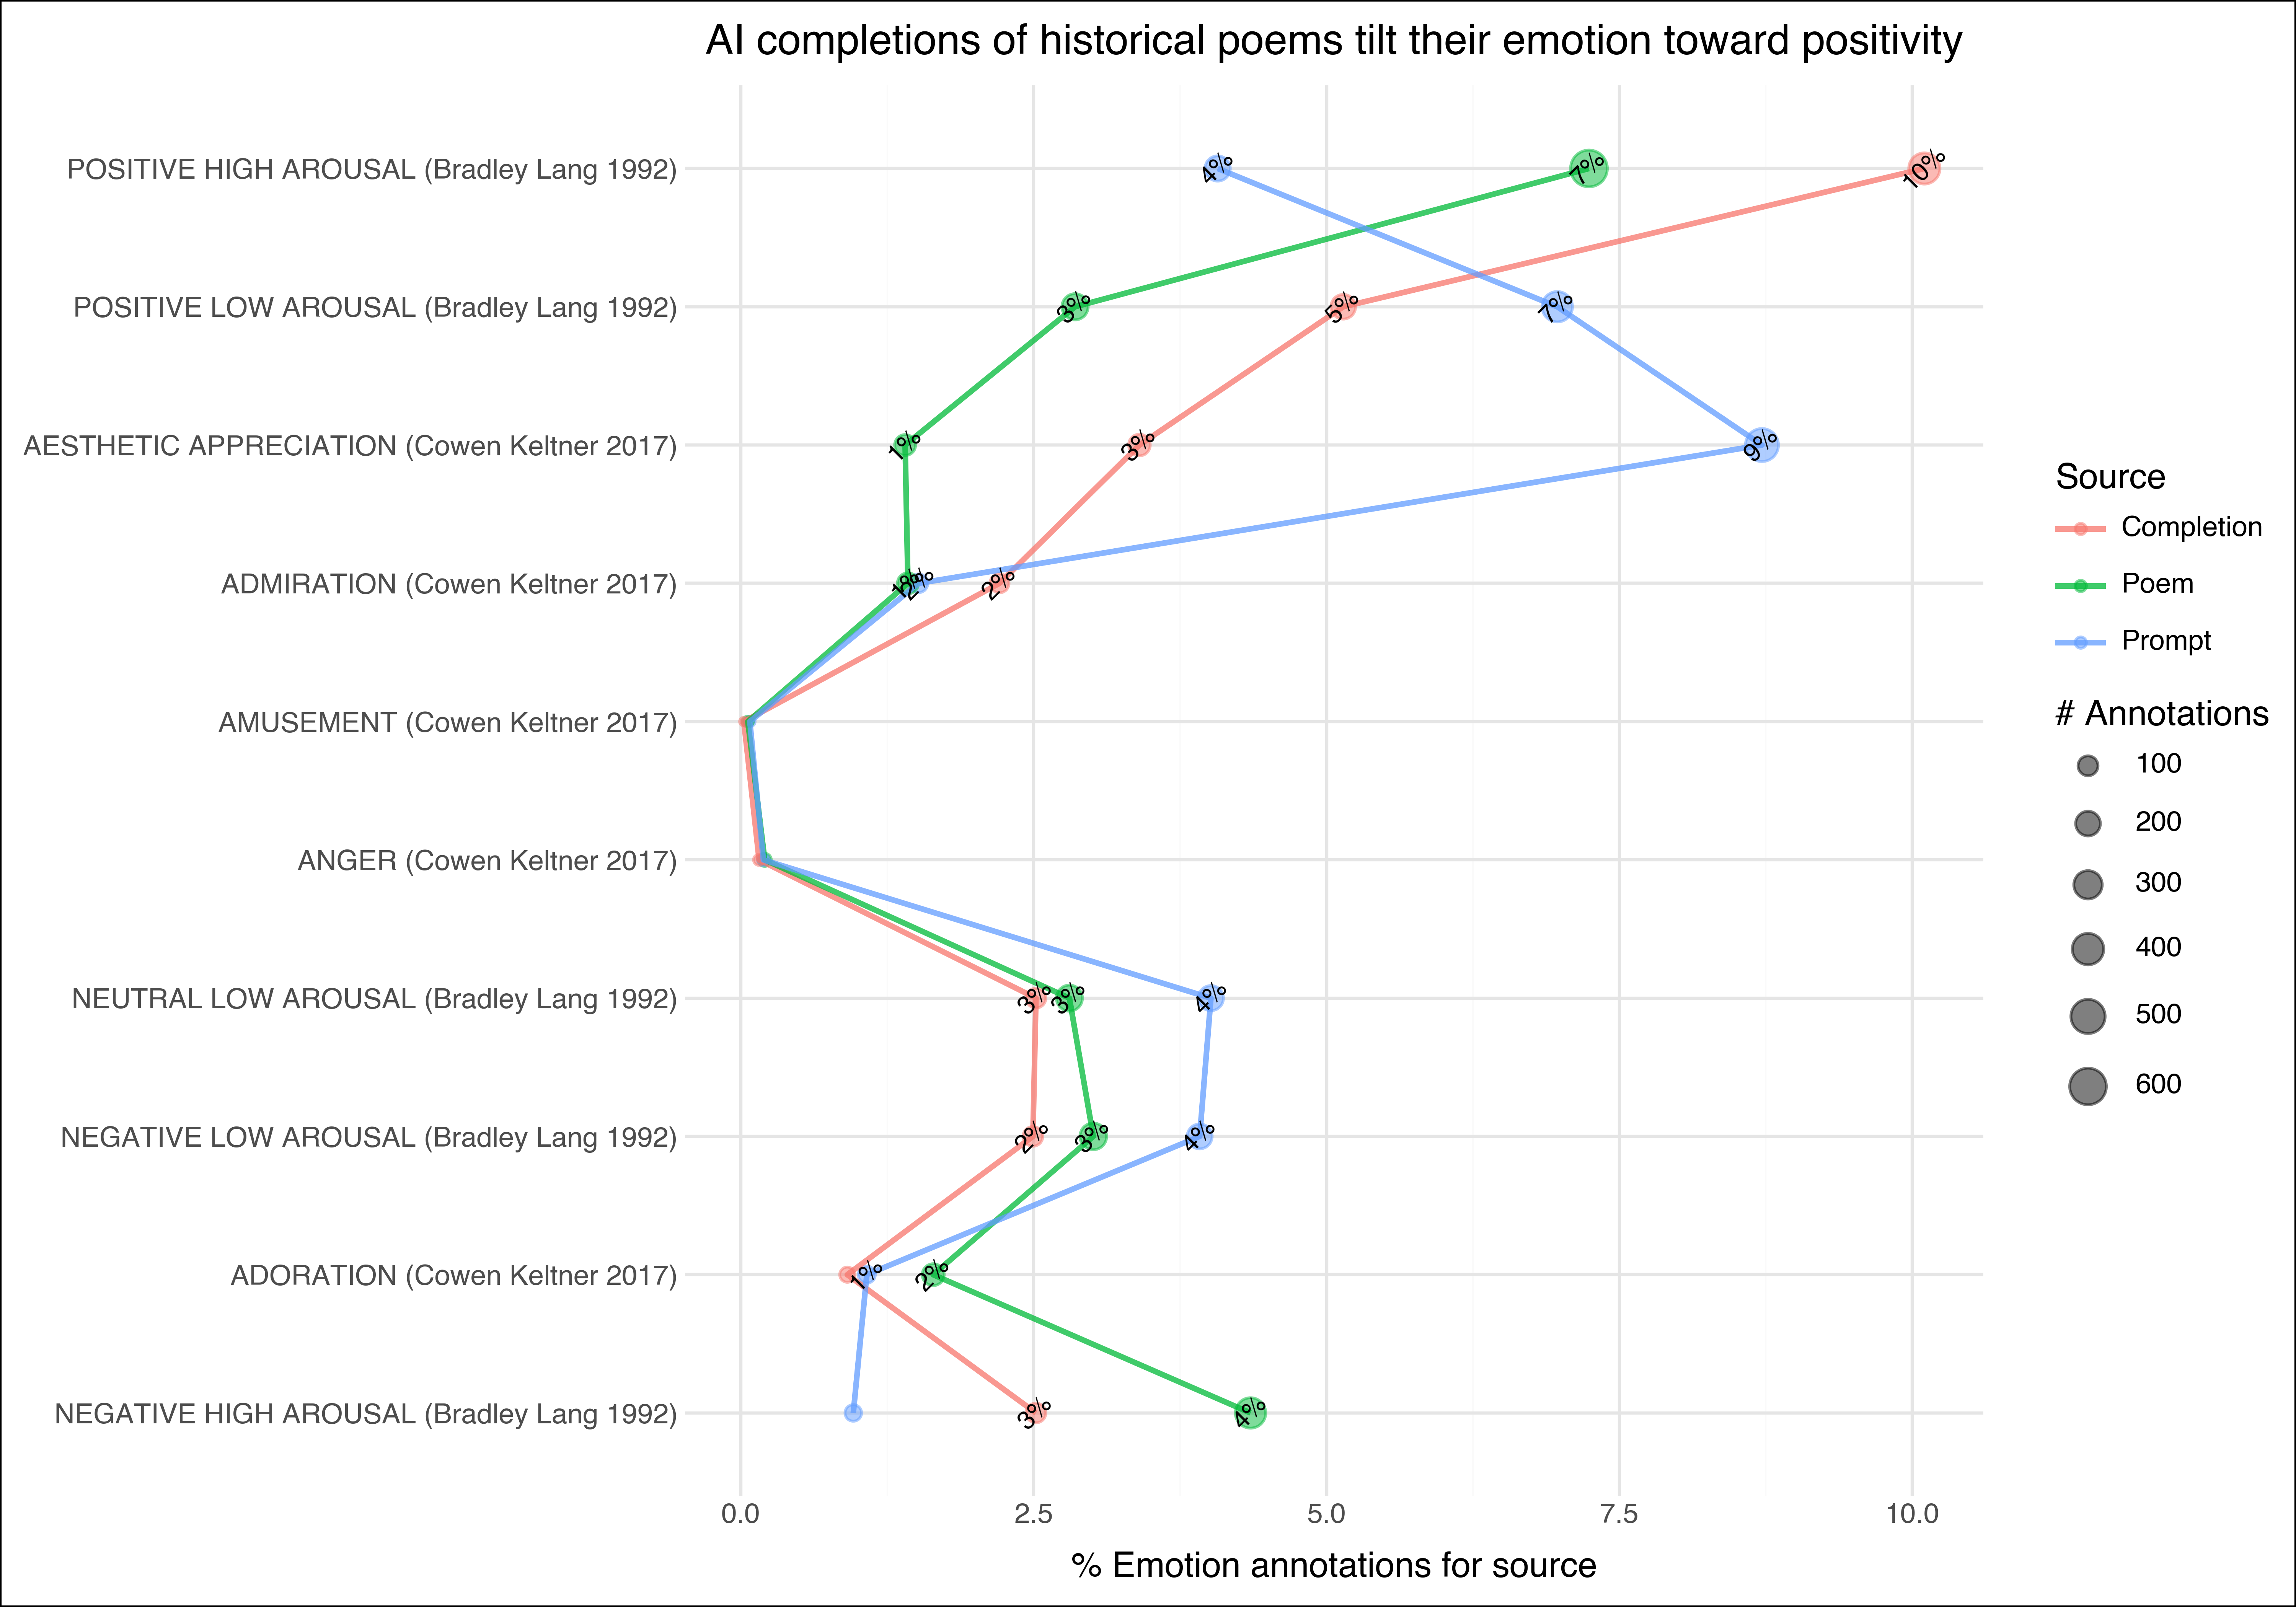

In [50]:
import plotnine as p9
p9.options.figure_size = (10, 7)
p9.options.dpi = 300
fig = (
    p9.ggplot(figdf, p9.aes(x="emo", y="perc")) 
    + p9.geom_point(p9.aes(color="source", size="eg"),alpha=0.5) 
    + p9.geom_line(p9.aes(group="source", color="source"), size=1, alpha=.75)
    # + p9.geom_smooth(p9.aes(linetype="source", group="source"), method="loess", span=0.5, se=False, size=.8)
    # + p9.facet_wrap("period",ncol=4)
    + p9.coord_flip()
    + p9.geom_text(p9.aes(label="perc_str"), size=8, angle=45, color="black") 
    + p9.theme_minimal()
    + p9.theme(
        plot_background=p9.element_rect(fill="white"),
        panel_background=p9.element_rect(fill="white"),
        # axis_text_y=p9.element_text(ha="right"),
        # axis_text_y=p9.element_text(ha="left")
    )
    # + p9.theme(legend_position="bottom")
    + p9.labs(
        y="% Emotion annotations for source",
        x="",
        color="Source",
        size="# Annotations",
        title="AI completions of historical poems tilt their emotion toward positivity"

    )
)
fig.save("fig.ai_poem_emotions.png")
fig
